In [6]:
import sys
sys.path.append("..")
from BacktestApp import BacktestApp
from utils import vwap, is_within_specific_minutes_of_close
from PositionManagerPlus import PositionManager

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
import scipy.optimize as optimize
import matplotlib.pyplot as plt

def fit_piecewise_segments(df, x_col, y_col, count, plot=False, highlight=None):
    """
    使用分段拟合对数据进行 Piecewise Regression (支持时间作为 X 轴)

    参数:
    - df: pd.DataFrame, 需要包含 x_col 和 y_col 两列
    - x_col: str, 作为 X 轴的列名 (如果是时间列，会自动转换为数值)
    - y_col: str, 作为 Y 轴的列名
    - count: int, 需要分的段数

    返回:
    - px: np.ndarray, 分段的 x 轴坐标（原始时间格式）
    - py: np.ndarray, 分段的 y 轴坐标
    """
    # 转换时间列为数值（时间戳 -> 秒级浮点数）
    X = pd.to_datetime(df[x_col]).astype(np.int64) / 1e9  # 转换为秒
    Y = df[y_col].values

    xmin = X.min()
    xmax = X.max()

    # 计算初始分段点
    seg = np.full(count - 1, (xmax - xmin) / count)
    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2) ** 2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')

    # 将 px 转回时间格式
    px, py = func(r.x)
    px = pd.to_datetime(px * 1e9)  # 秒 -> 纳秒时间戳
    slope = (py[1] - py[0]) / py[0] / len(df) * 10000
    if plot:
        plt.plot(df[x_col], df[y_col], ".")
        plt.plot(px, py, "-or")
        if highlight:
            # 找到对应的 y 值
            highlight_y = df.loc[df[x_col] == highlight, y_col].values[0]  # 获取对应的 y 值
            # 标红该点
            plt.scatter(highlight, highlight_y, color='red', s=80, zorder=3)
    return slope

class Trend:
    def __init__(self, contract, pm:PositionManager):
        self.contract = contract
        self.pm = pm
        
        self.break_up_price = None
        self.break_down_price = None
        
    def calculate_open_amount(self, bars):
        if self.pm.net_liquidation is None or self.pm.available_funds is None:
            print("PositionManager.calculate_open_amount net_liquidation or available_funds is None")
            return 0
        
        target_market_value = self.pm.net_liquidation * 0.1
        if target_market_value > self.pm.available_funds: return 0
        
        open_amount = target_market_value / bars.iloc[-1]['close']
        open_amount = round(open_amount / 10) * 10  # 调整为 10 的倍数
        return int(open_amount)

    def find_position(self):
        is_match = lambda item: (
            item["contract"] == self.contract and
            item["strategy"] == "Trend"
        )
        return self.pm.find_position(is_match)
    
    def setParams(self, bars, window=60, debug=True):
        bars['ema_10'] = bars['close'].ewm(span=10, adjust=False).mean()        
        bars['ema_10_shift_1'] = bars['ema_10'].shift(1)
        bars['remaining'] = len(bars) - bars.index
        close_price = bars.iloc[-1]['ema_10']
        bars['is_equal_close'] = ((bars['ema_10'] >= close_price) & (close_price >= bars['ema_10_shift_1'])) | \
                         ((bars['ema_10'] <= close_price) & (close_price <= bars['ema_10_shift_1']))
        bars['slope'] = np.nan
        bars['range_pct'] = np.nan
        for index, row in bars[bars['is_equal_close'] & (bars['remaining'] >= 90)].iterrows():
            df = bars.iloc[-1 * row["remaining"]:]
            bars.at[index, 'slope'] = fit_piecewise_segments(df, "date", "ema_10", count=1)
            bars.at[index, 'range_pct'] = (df['close'].max() - df['close'].min()) / df['close'].min()

        df = bars[bars['is_equal_close'] & (bars['remaining'] >= 90) & (bars['range_pct'] <= 0.02) & (bars['slope'].abs() < 2)]
        if len(df) != 0:
            min_slope_index = df['slope'].idxmin()
            df_slice = bars.loc[min_slope_index:]
            self.break_up_price = df_slice["close"].max()
            self.break_down_price = df_slice["close"].min()
        return bars
    
    def get_open_signal(self, bars):
        if (bars.iloc[-1]["close"] > self.break_up_price and bars.iloc[-2]["close"] < self.break_up_price):
            return "做多"
        if (bars.iloc[-1]["close"] < self.break_down_price and bars.iloc[-2]["close"] > self.break_down_price):
            return "做空"

    def get_close_signal(self, position, bars):
        """
        返回格式 减仓比例, 减仓原因
        减仓条件：
        1. 开仓后价格直接回到成交时的区间中轨，平仓（强制）
        2. 从最高点回落一半,平半仓（假突破）,回落到开仓价位以下时，再平半仓
        3. 如果走出单边走势,破ema10, 区间长度需要超过10分钟(止盈)
        """
        amount = position["amount"]
        
        ## 条件一
        # middle_price = (self.break_up_price + self.break_down_price) / 2
        # if (bars.iloc[-1]["close"] < middle_price and amount > 0) or \
        #     (bars.iloc[-1]["close"] > middle_price and amount < 0):
        #         # print(f'开仓时的时间点{self.open_position_df.iloc[0]["date"]}-{self.open_position_df.iloc[-1]["date"]} 中枢价格{middle_price} 当前价格{bars.iloc[-1]["close"]}')
        #         return 1, f"价格回落开仓区间中枢"
        
        ## 条件二
        df = bars[bars["date"] >= position["date"]]
        
        drawdown_ratio = 0.5
        max_profit_price = df["close"].min() if amount < 0 else df["close"].max()
        init_price = df.iloc[0]["close"]
        current_price = df.iloc[-1]["close"]
        # 区域限定的mask
        post_buy_pattern = None
        mask = (max_profit_price > current_price > init_price and amount > 0) or \
                (max_profit_price < current_price < init_price and amount < 0)
        # 回落比例 = (max_profit_price - current_price) / (max_profit_price - current_price)
        if len(df) > 3 \
            and (max_profit_price - init_price) != 0 \
            and (max_profit_price - current_price) / (max_profit_price - init_price) >= drawdown_ratio \
            and mask \
            and abs((current_price - init_price) / init_price) >= 0.002 \
            and position["amount"] == position["init_amount"]:
                post_buy_pattern = "回落走势"
                return 0.5, f"从最高点回落超过{drawdown_ratio}"
            
        if post_buy_pattern == "回落走势" \
            and ((current_price < init_price and amount > 0) or (current_price > init_price and amount < 0)):
            return 0.5, f"从最高点回落超过{drawdown_ratio}"
        
    def update(self, bars):
        if self.break_up_price is None: return
        if len(bars) < 2: return
        # 反手信号（平仓部分）
        position = self.find_position()
        open_single = self.get_open_signal(bars)
        if open_single:
            direction = 1 if open_single == "做多" else -1
            if position and direction * position["amount"] < 0:
                self.pm.close_position(position, bars)
        
        # 开仓信号
        position = self.find_position()
        if open_single and not position and not is_within_specific_minutes_of_close(bars, 60):
            direction = 1 if open_single == "做多" else -1
            amount = direction * self.calculate_open_amount(bars)
            self.pm.open_position(self.contract, "Trend", amount, bars)

        # 收盘前平仓
        position = self.find_position()
        if position and is_within_specific_minutes_of_close(bars, 1):
            self.pm.close_position(position, bars)
        
        # 常规止盈止损
        # position = self.find_position()
        # if position:
        #     close_signal = self.get_close_signal(position, bars)
        #     if close_signal:
        #         close_pct, reason = close_signal
        #         substract_amount = position["init_amount"] * close_pct
        #         if (substract_amount < position["amount"] and substract_amount > 0) or \
        #             (substract_amount > position["amount"] and substract_amount < 0):
        #             self.pm.substract_position(position, close_pct, bars, reason=reason)
        #         else:
        #             self.pm.close_position(position, bars, reason=reason)
        #             self.open_position_df = None
                    
class TrendBacktestApp(BacktestApp):
    def __init__(self, config_file="config.yml", **kwargs):
        super().__init__(config_file, **kwargs)
        self.trend = { contract.symbol: Trend(contract, self.pm) for contract in self.contracts }
        self.sideways_count = 0
        self.has_trade_count = 0
        
    def on_bar_update(self, contract, bars, has_new_bar):
        bars = bars.copy()
        self.trend[contract.symbol].update(bars)

        if len(bars) == 390:
            # if self.trend[contract.symbol].break_up_price is not None:
            #     self.sideways_count += 1
            #     df = pd.DataFrame(self.pm.trade_log)
            #     df = df[df['date'].dt.date == bars.iloc[-1]["date"].date()]
            #     if len(df) != 0: self.has_trade_count += 1
            
            self.trend[contract.symbol].break_up_price = None
            self.trend[contract.symbol].break_down_price = None
            self.trend[contract.symbol].setParams(bars)
            # print(bars.iloc[-1]["date"], self.trend[contract.symbol].break_up_price, self.trend[contract.symbol].break_down_price)

try:
    ba = TrendBacktestApp(config_file="../config_backtest.yml", clientId=20, debug=True, autoConnect=True)
    end_date = "2025-03-25"
    duration_str = "200 D"
    ba.minutes_backtest(end_date, duration_str)
finally:
    if ba.ib:
        ba.ib.disconnect()

【2024-06-07 09:48:00-04:00】【Trend】开仓: TSLA, 价格: 177.48, 数量：-560，浮动盈亏：None, 原因：None
【2024-06-07 15:59:00-04:00】【Trend】平仓: TSLA, 价格: 177.4, 数量：560，浮动盈亏：44.79999999999109, 原因：None
【2024-06-10 09:46:00-04:00】【Trend】开仓: TSLA, 价格: 178.03, 数量：560，浮动盈亏：None, 原因：None
【2024-06-10 11:01:00-04:00】【Trend】平仓: TSLA, 价格: 175.31, 数量：-560，浮动盈亏：-1523.1999999999994, 原因：None
【2024-06-10 11:01:00-04:00】【Trend】开仓: TSLA, 价格: 175.31, 数量：-570，浮动盈亏：None, 原因：None
【2024-06-10 15:59:00-04:00】【Trend】平仓: TSLA, 价格: 173.79, 数量：570，浮动盈亏：866.4000000000058, 原因：None
【2024-06-11 09:33:00-04:00】【Trend】开仓: TSLA, 价格: 172.31, 数量：-580，浮动盈亏：None, 原因：None
【2024-06-11 15:59:00-04:00】【Trend】平仓: TSLA, 价格: 170.58, 数量：580，浮动盈亏：1003.3999999999941, 原因：None
【2024-06-12 09:35:00-04:00】【Trend】开仓: TSLA, 价格: 172.07, 数量：580，浮动盈亏：None, 原因：None
【2024-06-12 15:59:00-04:00】【Trend】平仓: TSLA, 价格: 177.2, 数量：-580，浮动盈亏：2975.3999999999974, 原因：None
【2024-06-17 09:33:00-04:00】【Trend】开仓: TSLA, 价格: 179.76, 数量：560，浮动盈亏：None, 原因：None
【2024-06-17 15:59:00-04:00

In [7]:
from PlotPlus import PlotPlus
prev_lines = None
idx = 0

27 2024-07-17


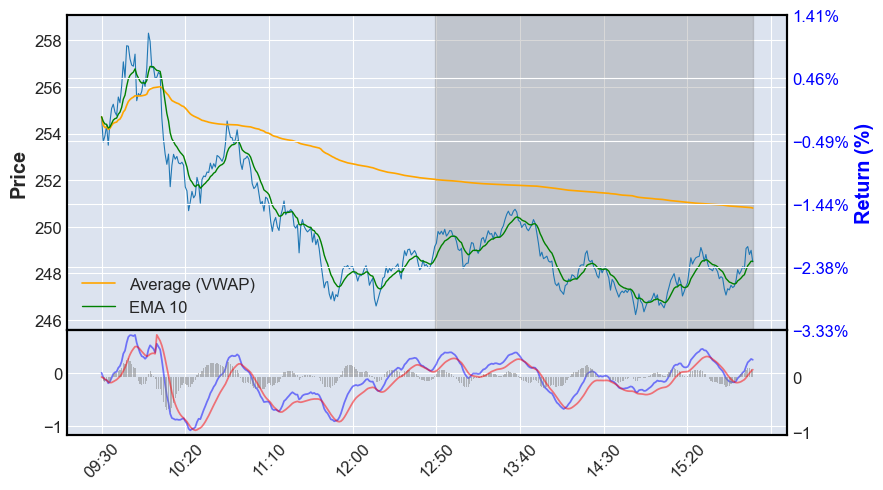

In [37]:
while True:
    daily = ba.get_historical_data(ba.contracts[0], end_date, duration_str, '1 day')
    date = daily.iloc[idx]['date']
    print(idx, date)
    idx += 1
    df = ba.get_historical_data(ba.contracts[0], date)
    st = Trend(ba.contracts[0], ba.pm)
    df = st.setParams(df, window=60)
    
    lines = []
    df["slope_segment"] = False
    df_slice = df[df['is_equal_close'] & (df['remaining'] >= 90) & (df['range_pct'] <= 0.02) & (df['slope'].abs() < 2)]
    if len(df_slice) != 0:
        min_slope_index = df_slice['slope'].idxmin()
        df.loc[min_slope_index:, "slope_segment"] = True
        # print(df.loc[min_slope_index:]["close"].min(), df.loc[min_slope_index:]["close"].max())
        lines.append(df.loc[min_slope_index:]["close"].min())
        lines.append(df.loc[min_slope_index:]["close"].max())
    else:
        lines = None

    pp = PlotPlus(df)
    pp.plot_basic(prev_lines)
    pp.mark_segment("slope_segment")
    pp.mark_bs_point(ba.pm.trade_log)
    pp.show()
    prev_lines = lines
    break

In [9]:
ba.statistic()

{'cumulative_pnl': np.float64(65004.361824000254),
 'max_drawdown': np.float64(0.012424964627351983),
 'sharpe_ratio': np.float64(1.1085926532723616),
 'volatility': np.float64(0.04113607453091022),
 'daily_return': np.float64(0.000319853769878696),
 'commission': np.float64(1644.037472)}

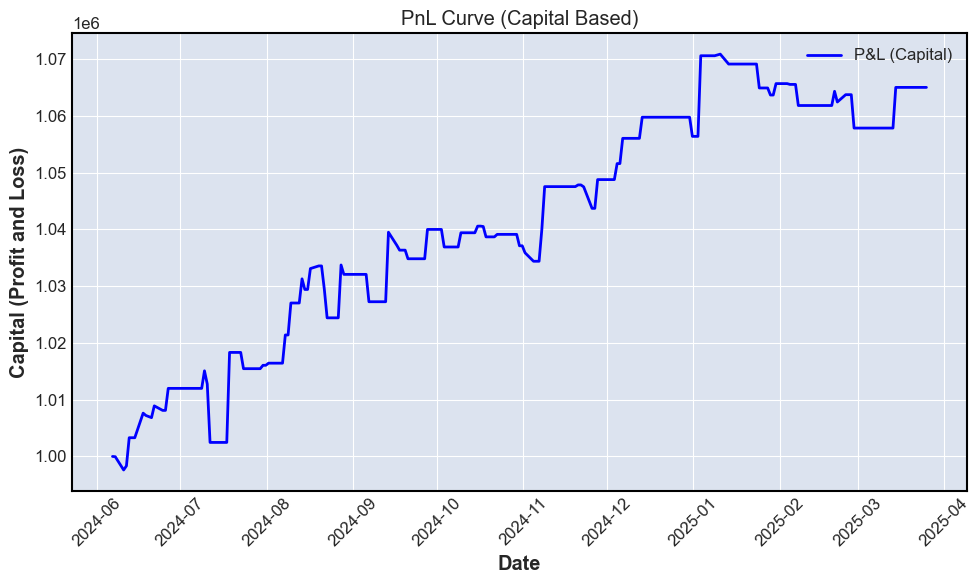

In [10]:
ba.plot_pnl()